In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from scipy.stats import kstest
from tqdm import tqdm

sns.set_style('darkgrid')
sns.set_context('talk')

rng = np.random.default_rng(16558947)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <    np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
# load data
df = pd.read_pickle('output.zip')

#df = reduce_mem_usage(df)

# create IDs columns
# df['id'] = "tau=" + df['tau'].astype(str) + ":inter=" + df['inter'].astype(str)# df['id'] = "tau=" + df['tau'].apply(str) + ":inter=" + df['inter'].apply(str)
# df['repid'] = df['id'] + ":rep=" + df['rep'].astype(str)

# list all identifiers
# ids = df['id'].unique()
# repids = df['repid'].unique()

Memory usage after optimization is: 612.70 MB
Decreased by 75.0%


In [4]:
df = reduce_mem_usage(df)
df

Memory usage after optimization is: 612.70 MB
Decreased by 0.0%


,t,N,rep,tau,inter,interRate,birthRate,births,deaths,events,sigma
0,0.367188,150.0,0.0,0.001,0.000001,0.0,149.0,50.0,0.0,50.0,0.000001
1,0.602051,200.0,0.0,0.001,0.000001,0.0,199.0,50.0,0.0,100.0,0.000001
2,0.831543,250.0,0.0,0.001,0.000001,0.0,249.0,50.0,0.0,150.0,0.000001
3,1.038086,300.0,0.0,0.001,0.000001,0.0,299.0,50.0,0.0,200.0,0.000001
4,1.217773,350.0,0.0,0.001,0.000001,0.0,349.0,50.0,0.0,250.0,0.000001
...,...,...,...,...,...,...,...,...,...,...,...
29202920,2080.000000,4.0,19.0,100.000,1.000000,3.0,3.0,26.0,24.0,9800.0,1.000000
29202921,2096.000000,4.0,19.0,100.000,1.000000,3.0,3.0,25.0,25.0,9848.0,1.000000
29202922,2102.000000,4.0,19.0,100.000,1.000000,10.0,5.0,25.0,25.0,9904.0,1.000000
29202923,2114.000000,2.0,19.0,100.000,1.000000,0.0,1.0,24.0,26.0,9952.0,1.000000


## Investigation of stop condition based on Binomial distribution

In [89]:
bdf = df[['newBirths', 'repid']].dropna()
bdf = bdf.groupby('repid').rolling(5).sum().iloc[::5].droplevel(1)

binom = sp.stats.binom(20, .5)

# b = [kstest(rvs=df[df['repid'] == repids[i]]['newBirths'][-40-d:-1-d], cdf='binom', args=(10, .5))[1] for i in range(len(repids)) for d in range(20)]
# b = [kstest(rvs=df[df['repid'] == repids[i]]['newBirths'][-40-d:-1-d], cdf='binom', args=(10, .5))[1] for i in range(len(repids)) for d in range(20)]
b = [kstest(rvs=bdf[bdf.index == repids[i]]['newBirths'][-40:], cdf='binom', args=(50, .5))[1] for i in range(len(repids))]


In [83]:
# 10
# pd.DataFrame(b).describe()

,0
count,2.000000e+02
mean,2.809713e-02
std,6.789964e-02
min,4.935443e-12
25%,3.244456e-04
50%,3.984335e-03
75%,2.599144e-02
max,4.995387e-01


In [86]:
# 20
# pd.DataFrame(b).describe()

,0
count,2.000000e+02
mean,1.118643e-01
std,1.555247e-01
min,6.124541e-17
25%,5.894833e-03
50%,3.724344e-02
75%,1.606885e-01
max,6.443476e-01


In [88]:
# 30
# pd.DataFrame(b).describe()

,0
count,2.000000e+02
mean,1.430347e-01
std,1.723369e-01
min,3.424335e-18
25%,1.424227e-02
50%,7.719168e-02
75%,1.898897e-01
max,8.089128e-01


In [81]:
# 40
# pd.DataFrame(b).describe()

,0
count,2.000000e+02
mean,2.037307e-01
std,2.042687e-01
min,4.595980e-25
25%,2.234152e-02
50%,1.241012e-01
75%,3.534940e-01
max,8.008253e-01


In [93]:
# 50
# pd.DataFrame(b).describe()

,0
count,2.000000e+02
mean,2.319892e-01
std,2.160015e-01
min,2.188625e-30
25%,4.864107e-02
50%,1.820070e-01
75%,3.784447e-01
max,9.048294e-01


In [ ]:
for i in range(len(repids)):
    sns.histplot(a[a.index == repids[i]][-100:])
    plt.show()

In [ ]:
for i in range(len(repids)):
    mean = 20/2
    std = np.sqrt(1/20)/2

    norm = sp.stats.norm.fit(a[a.index == repids[i]][-100:])
    xs = np.linspace(0,20)
    # rv = sp.stats.norm((mean, std))

    ax = plt.gca()
    # ax.plot(xs, norm.pdf(xs), 'k-', lw=2, label='frozen pdf')
    ax.plot(xs, sp.stats.norm.cdf(xs, loc=mean, scale=std), 'r-', lw=5, alpha=0.6, label='norm pdf')
    # sns.histplot()
    plt.show()

## Test the stop condition and carrying capacities


In [299]:
def stop_condition(data, N, check_termination_N_data=40):
    # identify if the number of births follows a binomial (gaussian) distribution    
    # N = self.data_interval

    X = data['births'][-check_termination_N_data:]

    # test if there is a sufficient number of observations
    # if N > 9:

    # test if skewness is sufficiently low
    # if skew(X) < 1/3:

    # test if observations follow a gaussian distribution and return
    # test if p-value is greater than .5
    # (20% of kstests with the same RVS and CDF generate p-value > .5)
    return kstest(rvs=X, cdf='binom', args=(N, .5))[1] > .5
    
def generate_CDF(X, N):
    """Receives a vector of observations and returns the empirical CDF with support [0,N].

    Args:
        X (np.array): Vector of observations
        N (int): upper limit of the support

    Returns:
        np.array: The vector containing the values of the empirical CDF. Output is a N+1 dimensional numpy vector.
    """
    
    # All but the last (righthand-most) bin is half-open.
    # the last bin need to be [N, N+1]
    bin_limits = np.arange(0,N+2)
    CDF = np.histogram(X, bins=bin_limits, density=True)[0].cumsum()
    return CDF

def kolmogorov_like_test(CDFn, CDFtheo):
    # N = CDFn.shape[0]
    # assert CDFtheo.shape == CDFn.shape, "CDFs must have the same shape"

    # returns the maximum absolute difference between the theoretical and empirical CDFs
    return np.max(np.abs(CDFn-CDFtheo))
    
def generate_binom_theoreticalCDF(N, p):
    """Generates the theoretical CDF of the binomial distribution with $N$ samples and probability of success $p$.

    Args:
        N (int): Number of samples
        p (float): probability of success

    Returns:
        np.array: The vector containing the values of the theoretical CDF. Output is a N+1 dimensional numpy vector.
    """
    dist = sp.stats.binom(N, p)
    xs = np.arange(0,N+1)
    CDF = dist.cdf(xs)
    return CDF

In [302]:
b = sp.stats.binom(50, .5).rvs(40)

In [303]:
%%timeit
kolmogorov_like_test(CDFn=generate_CDF(X=b, N=50), CDFtheo=theo_cdf)

58.6 µs ± 469 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [300]:
xs = np.arange(0,51)
theo_cdf = sp.stats.binom.cdf(xs, 50, .5)

In [112]:
stats = [np.max(np.abs(theo_cdf-vish(df[df['repid'] == repids[i]]['births'][-40:]))) for i in tqdm(list(range(len(repids))))]
stats2 = pd.Series(stats)
(stats2 * np.sqrt(40)).describe()

In [305]:
a = [kolmogorov_like_test(CDFn=generate_CDF(X=sp.stats.binom(50, .5).rvs(40), N=50), CDFtheo=theo_cdf) for _ in tqdm(range(100000))]
a = pd.DataFrame(a)

100%|██████████| 100000/100000 [01:08<00:00, 1469.51it/s]


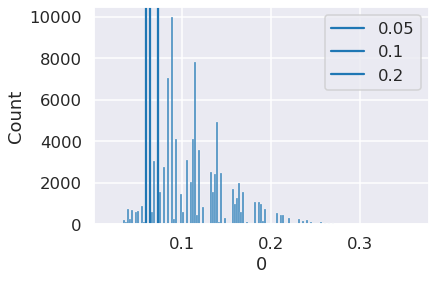

In [306]:
ax = sns.histplot(a[0])#.quantile(.999)
for q in [.05, .1, .2]:
    ax.axvline(x=a.quantile(q)[0], label=str(q))
ax.legend()
plt.show()


In [308]:
a.quantile(.5)

0    0.106138
Name: 0.5, dtype: float64

### CDF-CDF plots

In [ ]:
from time import sleep

for i in range(len(repids)):
    dat = df[df['repid'] == repids[i]]

    xs = np.arange(0,51)
    

    # theo_cdf = sp.stats.binom.cdf(xs, 50, .5)

    ys = dat['births'][-40:]
    

    hist, bin_edges = np.histogram(ys, bins=xs)
    sim_cdf = list(np.cumsum(hist)/40)
    # sim_cdf.append(1.)
    sim_cdf = np.array(sim_cdf)
    
    # equilibrium = ks_2samp(sim_cdf, theo_cdf)[1]#stop_condition(data=dat, N=50)

    ax = plt.gca()
    ax.plot(xs, sim_cdf, 'k-', lw=2, label="simulated")
    ax.plot(xs, theo_cdf, 'g-.', lw=2, label="theoretical")

    maxdif_idx = int(np.argmax(np.abs(theo_cdf-sim_cdf)))
    ymin = np.min([sim_cdf[maxdif_idx], theo_cdf[maxdif_idx]])
    ymax = np.max([sim_cdf[maxdif_idx], theo_cdf[maxdif_idx]])

    dn = np.sqrt(40)*(ymax-ymin)
    equilibrium = dn
    
    ax.vlines(x=maxdif_idx, ymin=ymin, ymax=ymax, colors='r', linewidth=3, zorder=3, label=f'{ymax-ymin:.1}')
    ax.axhline(ymin, color='r', linewidth=1, zorder=3)
    ax.axhline(ymax, color='r', linewidth=1, zorder=3)

    ax.set_title(f"i={i}   {repids[i]}" + '\n' + \
        str(kstest(rvs=ys, cdf='binom', args=(50, .5))) + '\n' + \
    str(equilibrium))
    ax.legend()
    plt.show()

    # sleep(1)


    # if equilibrium:
    #     ax = plt.gca()
    #     ax.plot(dat['t'], dat['N'], 'o')
    #     ax.set_title(f"{repids[i]} | Eq.? {equilibrium}")
    #     plt.show()

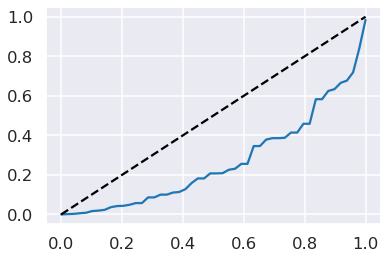

In [95]:
xs = np.linspace(0,1)
plt.plot(xs, test.quantile(xs))
plt.plot([0,1], [0,1], 'k--')

### Abundance, Variance and Skewness Plot

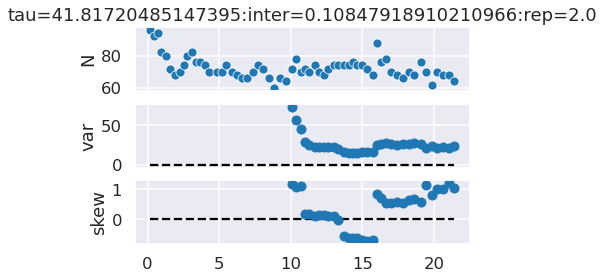

In [6]:
r=repids[209]
dat = df[df['repid'] == r]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)

ax1.set_title(r)
sns.scatterplot(data=dat, x='t', y='N', legend=False, ax=ax1)

ax2.set_ylabel('var')
ax2.plot(dat['t'], dat['N'].rolling(30).var(), 'o')
ax2.hlines(0., xmin=dat['t'].min(), xmax=dat['t'].max(), colors='k', linestyles='dashed')

ax3.set_ylabel('skew')
ax3.plot(dat['t'], dat['N'].rolling(30).skew(), 'o')
ax3.hlines(0., xmin=dat['t'].min(), xmax=dat['t'].max(), colors='k', linestyles='dashed')
plt.show()
# ax.set_ysc

In [ ]:
for r in repids:
    dat = df[df['repid'] == r]
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
    
    ax1.set_title(r)
    sns.scatterplot(data=dat, x='t', y='N', legend=False, ax=ax1)
    
    ax2.set_ylabel('var')
    ax2.plot(dat['t'], dat['N'].rolling(30).var(), 'o')
    ax2.hlines(0., xmin=dat['t'].min(), xmax=dat['t'].max(), colors='k', linestyles='dashed')
    
    ax3.set_ylabel('skew')
    ax3.plot(dat['t'], dat['N'].rolling(30).skew(), 'o')
    ax3.hlines(0., xmin=dat['t'].min(), xmax=dat['t'].max(), colors='k', linestyles='dashed')
    plt.show()
    # ax.set_yscale('log')

## Carrying Capacity Heatmap

In [5]:
def prepare_heatmap_data(df, xdivs, ydivs, xvar, yvar, zvars, aggr_fun=np.mean):
    
    minx = df[xvar].min()
    maxx = df[xvar].max()
    miny = df[yvar].min()
    maxy = df[yvar].max()

    # CREATE DATA
    
    x_linsp = np.linspace(minx, maxx, xdivs+1)
    y_linsp = np.linspace(miny, maxy, ydivs+1)
    
    data_list = []
    
    for x in range(xdivs):
        for y in range(ydivs):
            data_filtered = df[(df[xvar] >= x_linsp[x])
                                 & (df[xvar] < x_linsp[x+1])
                                 & (df[yvar] >= y_linsp[y])
                                 & (df[yvar] < y_linsp[y+1])
                                ]
            input_dict = {'x': aggr_fun([x_linsp[x], x_linsp[x+1]]),
                           'y': aggr_fun([y_linsp[y], y_linsp[y+1]])}
            vars_dict = {v: np.mean(data_filtered[v]) for v in zvars}
            joined_dict = input_dict | vars_dict
            
            data_list.append(joined_dict)
    
    heat_data = pd.DataFrame(data_list)
    return heat_data

def heatmap_tick_locator(values, ndivs, minv, maxv):
        return [ndivs*(v-minv)/(maxv) for v in values]

def plot_heatmap(data, xvar, yvar, zvar, figsize=None, fig_kwargs=None, **kwargs):
    
    # SETUP
    if fig_kwargs is not None:
        fig, (ax, cax) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=figsize, **fig_kwargs)
    else:
        fig, (ax, cax) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=figsize)

    # HEATMAP
    sns.heatmap(data=data.pivot(index=yvar,
                                    columns=xvar,
                                    values=zvar),
                cmap='viridis',
                cbar_kws={'label': zvar
                        },
                cbar_ax=cax,
                square=True,
                ax=ax,
                **kwargs
            )

    # LABELS
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

    # Y-AXIS
    # tick_values = np.arange(0.25, 2.1, 0.25)
    # ax.invert_yaxis()
    # ax.yaxis.set_ticks(heatmap_tick_locator(values=tick_values, ndivs=ndivs, minv=np.min(x_linsp), maxv=np.max(x_linsp)))
    # ax.yaxis.set_ticklabels([f"{x:3.2f}" for x in tick_values])

    # # X-AXIS
    # tick_values = np.arange(0.1, 0.51, 0.1)
    # ax.xaxis.set_tick_params(rotation = 0)
    # ax.xaxis.set_ticks(heatmap_tick_locator(values=tick_values, ndivs=ndivs, minv=np.min(y_linsp), maxv=np.max(y_linsp)))
    # ax.xaxis.set_ticklabels([f"{x:3.2f}" for x in tick_values])

    # COLORBAR
    cax.set_yticklabels([f"{x:.0e}" for x in cax.get_yticks()])

    # plt.tight_layout()
    # plt.savefig(save_folder+'heatmap_density_stdev_propBounded.pdf')
    # plt.savefig(save_folder+'heatmap_density_stdev_propBounded.png')
    return ax

In [12]:
df = df[df['events'] > 8000]

In [9]:
data_list = []
for t in df['tau'].unique():
    for i in df['inter'].unique():
        data_filtered = df[(df['tau'] == t)
                        & (df['inter'] == i)
                        ]

        data_filtered = data_filtered.nlargest(40*50, 'events')
        data_list.append(data_filtered)

In [13]:
df2 = pd.DataFrame(data_list[0])

for d in data_list[1:]:
    df2 = df2.append(d)

In [15]:
df2 = reduce_mem_usage(df2)

Memory usage after optimization is: 22.89 MB
Decreased by 0.0%


In [53]:
#BUG

# df['inter'] #= df['sigma']

#BUG

zvars = ['N']

# res = []
# for r in df['repid'].unique():
#     res.append(df[df['repid'] == r][df[df['repid'] == r]['events'] >= df[df['repid'] == r]['events'].max() - 40*50])

# df2 =  pd.concat(res)
# df2 = df

data_list = []
for t in df['tau'].unique():
    for i in df['inter'].unique():
        data_filtered = df2[(df2['tau'] == t)
                        & (df2['inter'] == i)
                        ]

        data_filtered.nlargest(40*50, 'events')

        input_dict = {
            'tau': t,
            'inter': i
            }
        means_dict = {v: np.mean(data_filtered[v]) for v in zvars}
        std_dict = {v+'-std': np.std(data_filtered[v]) for v in zvars}

        joined_dict = input_dict | means_dict | std_dict
        
        data_list.append(joined_dict)

heat_data = pd.DataFrame(data_list)

In [30]:
df2 = df2.reset_index(drop=True)

In [47]:
df2 = df2.dropna()

In [50]:
df2['N'] = df2['N'].astype(float)

In [52]:
df2['N'].describe()

count    800000.000000
mean       6553.151165
std        4361.367713
min           2.000000
25%         606.500000
50%        9848.000000
75%       10000.000000
max       10096.000000
Name: N, dtype: float64

In [54]:
heat_data

,tau,inter,N,N-std
0,0.001,0.000001,10000.000,67.882251
1,0.001,0.000002,10000.000,67.882251
2,0.001,0.000004,10000.000,67.882251
3,0.001,0.000009,10000.000,67.882251
4,0.001,0.000018,9999.948,67.958791
...,...,...,...,...
395,100.000,0.054565,296.586,39.556499
396,100.000,0.112854,77.884,10.631582
397,100.000,0.233521,21.566,4.507732
398,100.000,0.483398,7.520,2.485478


/tmp/ipykernel_1458747/709399012.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels([f"{x:.0e}" for x in cax.get_yticks()])


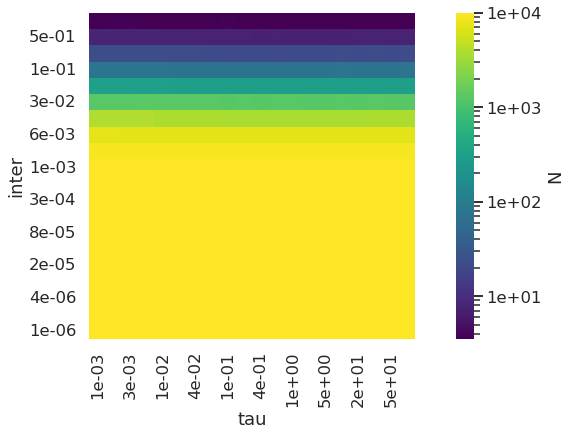

In [55]:
ax = plot_heatmap(heat_data, xvar='tau', yvar='inter', zvar='N', figsize=(7,6), norm=LogNorm())#, fig_kwargs={'facecolor': '#fff9db'})

xtext = ax.xaxis.get_ticklabels()
xtext = [f"{float(x.get_text()):.0e}" for x in xtext]
ax.xaxis.set_ticklabels(xtext)

ytext = ax.yaxis.get_ticklabels()
ytext = [f"{float(x.get_text()):.0e}" for x in ytext]
ax.yaxis.set_ticklabels(ytext)

ax.invert_yaxis()



/tmp/ipykernel_3281043/709399012.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels([f"{x:.0e}" for x in cax.get_yticks()])


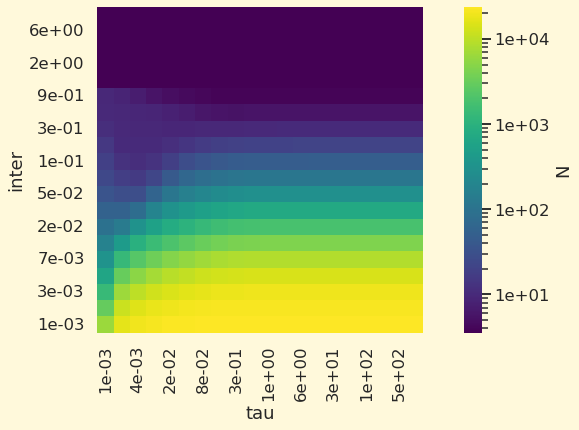

In [81]:
ax = plot_heatmap(heat_data, xvar='tau', yvar='inter', zvar='N', figsize=(7,6), norm=LogNorm(), fig_kwargs={'facecolor': '#fff9db'})

xtext = ax.xaxis.get_ticklabels()
xtext = [f"{float(x.get_text()):.0e}" for x in xtext]
ax.xaxis.set_ticklabels(xtext)

ytext = ax.yaxis.get_ticklabels()
ytext = [f"{float(x.get_text()):.0e}" for x in ytext]
ax.yaxis.set_ticklabels(ytext)

ax.invert_yaxis()



In [83]:
inters = df['inter'].unique()
inters.sort()
inters[::2]

array([1.00000000e-03, 2.63665090e-03, 6.95192796e-03, 1.83298071e-02,
       4.83293024e-02, 1.27427499e-01, 3.35981829e-01, 8.85866790e-01,
       2.33572147e+00, 6.15848211e+00])

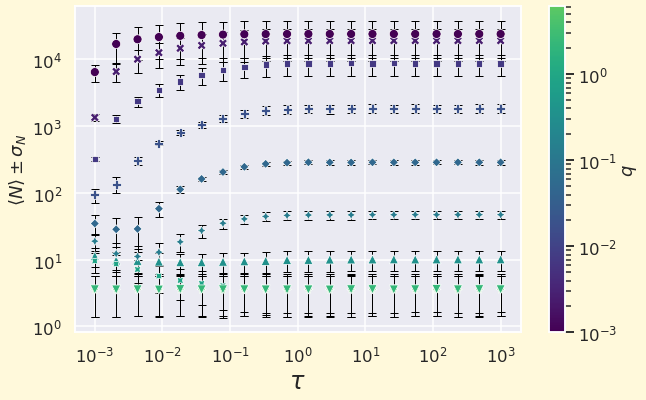

In [85]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
sns.set_style('darkgrid')

# cmap = sns.cubehelix_palette(start=.5, rot=-.45, dark=.2, as_cmap=True, reverse=True)#sns.color_palette('viridis', as_cmap=True)
# cmap = sns.desaturate(cmap, .3)

cmap = ListedColormap(mpl.cm.get_cmap('viridis')(np.linspace(0., 0.75, 256)))

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.scatterplot(data=heat_data[heat_data['inter'].isin(inters[::2])], x='tau', y='N', hue='inter', style='inter', hue_norm=LogNorm(), palette=cmap, legend=False, zorder=2)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
ax.errorbar(x_coords, y_coords, yerr=heat_data[heat_data['inter'].isin(inters[::2])]['N-std'], fmt='k ', lw=1, capsize=4, capthick=1, zorder=1)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'$ \left\langle N \right\rangle \pm \sigma_N $')
ax.set_xlabel(r'$ \tau $', fontsize=24)

psm = ScalarMappable(norm=LogNorm(vmin=inters[::2].min(), vmax=inters[::2].max()), cmap=cmap)
fig.colorbar(psm, ax=ax, label=r'$q$')
# fig.colorbar()
fig.set_facecolor("#fff9db")


/tmp/ipykernel_3281043/709399012.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels([f"{x:.0e}" for x in cax.get_yticks()])


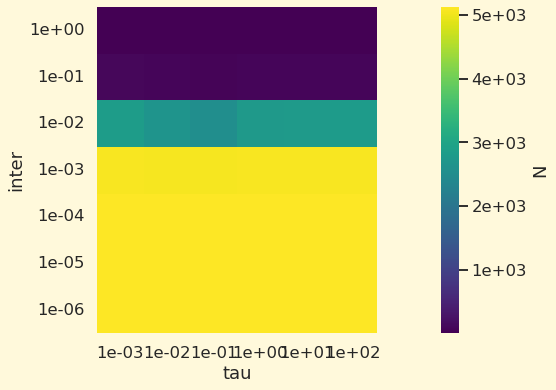

In [71]:
ax = plot_heatmap(heat_data, xvar='tau', yvar='inter', zvar='N', figsize=(7,6), fig_kwargs={'facecolor': '#fff9db'})

xtext = ax.xaxis.get_ticklabels()
xtext = [f"{float(x.get_text()):.0e}" for x in xtext]
ax.xaxis.set_ticklabels(xtext)

ytext = ax.yaxis.get_ticklabels()
ytext = [f"{float(x.get_text()):.0e}" for x in ytext]
ax.yaxis.set_ticklabels(ytext)

ax.invert_yaxis()



Text(0.5, 1.0, '$q = 3\\times 10^{-1}$')

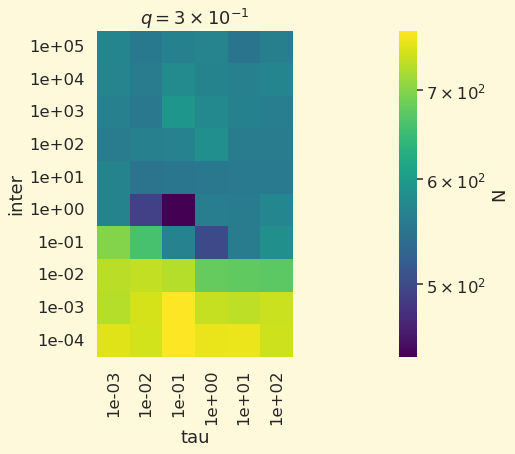

In [58]:
ax = plot_heatmap(heat_data, xvar='tau', yvar='inter', zvar='N', figsize=(7,6), norm=LogNorm(), fig_kwargs={'facecolor': '#fff9db'})

xtext = ax.xaxis.get_ticklabels()
xtext = [f"{float(x.get_text()):.0e}" for x in xtext]
ax.xaxis.set_ticklabels(xtext)

ytext = ax.yaxis.get_ticklabels()
ytext = [f"{float(x.get_text()):.0e}" for x in ytext]
ax.yaxis.set_ticklabels(ytext)

ax.invert_yaxis()

ax.set_title(r'$q = 3\times 10^{-1}$')



In [ ]:
for id in df[df['sigma'] == 1.]['repid'].unique():
    ax = plt.gca()
    ax.plot(df[df['sigma'] == 1.][df['repid']==id]['t'], df[df['sigma'] == 1.][df['repid']==id]['N'])
    plt.show()
    input()

In [12]:
intervalue = np.sort(heat_data['inter'].unique())[5]
heat_data[heat_data['inter'] == intervalue]

,tau,inter,N,N-std
9,0.039102,0.010415,3917.853659,116.930824
24,0.223607,0.010415,3777.365854,131.847243
39,41.817205,0.010415,3999.853659,132.058221
54,0.006838,0.010415,4098.351220,131.243485
69,3.057877,0.010415,3653.004878,103.493066
84,0.093506,0.010415,3844.243902,117.421397
99,17.486786,0.010415,3928.897561,116.915372
114,0.001196,0.010415,4381.131707,147.322269
129,7.312485,0.010415,3819.717073,125.722334
144,100.000000,0.010415,3979.795122,122.260246


In [5]:
def rho(tau, g=1., h=0.95):
    k = np.sqrt(-np.log(1-h))
    return np.sqrt(g*tau)*k

def sigma(tau, g=1.):
    stdev = np.sqrt(g*tau/2)
    return stdev

def inter_rate_OU(tau):
    pass

def critical_distances():
    pass

def inter_rate_BM(R, q, gamma=1.):
    # equation 20 Martinez-Garcia 2020
    return gamma*(1.-4*q/(3*np.pi*R))/(np.pi*R*R)

def carrying_cap_BM(b, R, q, gamma=1.):
    return b/inter_rate_BM(R=R, q=q, gamma=gamma)

def area_dens(radius, totarea = 100., dens=3*np.sqrt(3)/2):
    individual_area = dens*radius*radius
    return totarea/individual_area

def inter_rate(inter_radius):
    return 1./(np.pi*inter_radius*inter_radius)

def sessile_pred(birth, inter_radius, tot_area = 100.):
    gamma = inter_rate(inter_radius=inter_radius)
    return (birth/gamma + 1)*(tot_area/(np.pi*inter_radius*inter_radius))*2*np.sqrt(3)/3

In [12]:
def sessile_pred(birth, inter_radius, gamma, tot_area = 100.):
    gamma = gamma
    return (birth/gamma + 1)*(tot_area/(np.pi*inter_radius*inter_radius))*2*np.sqrt(3)/3

sessile_pred(2., .3, 1., 16)/16/2

6.125876615797689

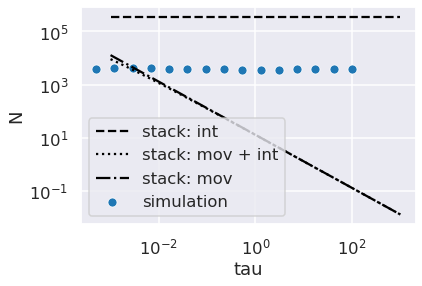

In [14]:
# intervalue = 

xs = np.geomspace(1e-3, 1e3)

ys = [area_dens(intervalue) for _ in xs]
ys2 = [area_dens(intervalue+rho(x)) for x in xs]
ys3 = [area_dens(rho(x)) for x in xs]


ax = sns.scatterplot(data=heat_data[heat_data['inter'] == intervalue], x='tau', y='N', label='simulation', legend=False)
# ax = sns.scatterplot(data=heat_data, x='tau', y='N', hue='intervalue', palette='coolwarm')#, label='simulation', legend=False)
ax.plot(xs, ys, 'k--', label='stack: int')
ax.plot(xs, ys2, 'k:', label='stack: mov + int')
ax.plot(xs, ys3, 'k-.', label='stack: mov')

# plt.figlegend()
ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')



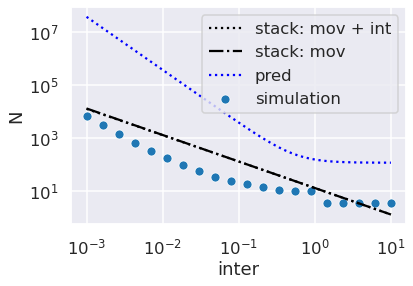

In [32]:
tau = 0.001

#inters
xs = np.geomspace(1e-3, 1e1)

ys = [area_dens(tau) for _ in xs]
ys2 = [area_dens(tau+rho(x)) for x in xs]
ys3 = [area_dens(rho(x)) for x in xs]
ysSessile = [sessile_pred(birth=1., inter_radius=inter) for inter in xs]


ax = sns.scatterplot(data=heat_data[heat_data['tau'] == tau], x='inter', y='N', label='simulation', legend=False)
# ax = sns.scatterplot(data=heat_data, x='tau', y='N', hue='inter', palette='coolwarm')#, label='simulation', legend=False)
# ax.plot(xs, ys, 'k--', label='stack: int')
ax.plot(xs, ys2, 'k:', label='stack: mov + int')
ax.plot(xs, ys3, 'k-.', label='stack: mov')
ax.plot(xs, ysSessile, 'b:', label='pred')

# plt.figlegend()
ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')



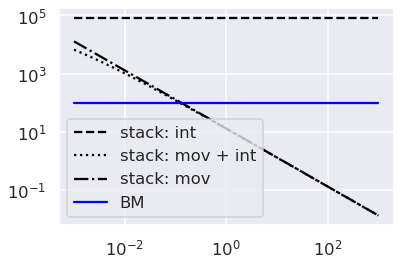

In [33]:
inter = 0.021544346900318832

xs = np.geomspace(1e-3, 1e3)

ys = [area_dens(inter) for _ in xs]
ys2 = [area_dens(inter+rho(x)) for x in xs]
ys3 = [area_dens(rho(x)) for x in xs]

Requiv = np.sqrt(100/np.pi)

ysBM = [carrying_cap_BM(b=1., R=Requiv, q=inter) for _ in xs]

g = 1.
tau = 0.001
stdev = np.sqrt(g*tau/2)
k = np.sqrt(-np.log(1-0.95))
rho = np.sqrt(g*tau)*k

ax = sns.scatterplot(data=heat_data[heat_data['inter'] == inter], x='tau', y='N', label='simulation', legend=False)
# ax = sns.scatterplot(data=heat_data, x='tau', y='N', hue='inter', palette='coolwarm')#, label='simulation', legend=False)
ax.plot(xs, ys, 'k--', label='stack: int')
ax.plot(xs, ys2, 'k:', label='stack: mov + int')
ax.plot(xs, ys3, 'k-.', label='stack: mov')
ax.plot(xs, ysBM, 'b-', label='BM')

# plt.figlegend()
ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')



In [93]:
df[]

,t,N,rep,tau,inter,interRate,birthRate,births,deaths,events
id,,,,,,,,,,
tau=0.001:inter=0.001,7.745440,8065.785,4.5,0.001000,0.001000,7816.2475,8065.835,25.5725,24.4275,49025.0
tau=0.001:inter=0.001623776739188721,11.240300,3321.920,4.5,0.001000,0.001624,3339.1250,3321.910,24.5950,25.4050,49025.0
tau=0.001:inter=0.0026366508987303583,20.566745,1387.585,4.5,0.001000,0.002637,1392.4850,1387.525,25.2275,24.7725,49025.0
tau=0.001:inter=0.004281332398719396,40.330234,628.955,4.5,0.001000,0.004281,630.0100,629.000,25.0800,24.9200,49025.0
tau=0.001:inter=0.0069519279617756054,77.101493,300.000,4.5,0.001000,0.006952,302.4300,300.010,24.9425,25.0575,49025.0
...,...,...,...,...,...,...,...,...,...,...
tau=6.158482110660261:inter=1.438449888287663,10595.753105,3.545,4.5,6.158482,1.438450,5.6625,3.535,25.0100,24.9900,49025.0
tau=6.158482110660261:inter=10.0,10583.510423,3.420,4.5,6.158482,10.000000,5.3550,3.410,25.0125,24.9875,49025.0
tau=6.158482110660261:inter=2.3357214690901213,10564.913988,3.465,4.5,6.158482,2.335721,5.4825,3.475,24.9925,25.0075,49025.0


In [90]:
heat_data.set_index(['tau', 'inter'])

N
tau      inter               
0.002069 0.018330    135.2646
         0.078476     17.7462
         0.048329     28.3410
         0.006952   1283.3734
         0.029764     54.1136
...                       ...
0.162378 0.011288   3684.6230
         0.127427     40.5670
         0.001624  21731.0788
         0.002637  18173.8068
         0.001000  23693.4876

[400 rows x 1 columns]

In [16]:
inters = df['inter'].unique()
inters.sort()
inters[::2]

array([0.001     , 0.00255311, 0.00651836, 0.01664209, 0.04248906,
       0.10847919, 0.27695915, 0.70710678])

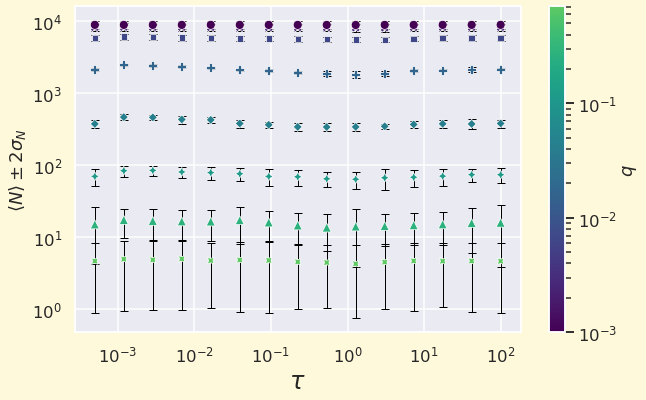

In [17]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
sns.set_style('darkgrid')

# cmap = sns.cubehelix_palette(start=.5, rot=-.45, dark=.2, as_cmap=True, reverse=True)#sns.color_palette('viridis', as_cmap=True)
# cmap = sns.desaturate(cmap, .3)

cmap = ListedColormap(mpl.cm.get_cmap('viridis')(np.linspace(0., 0.75, 256)))

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.scatterplot(data=heat_data[heat_data['inter'].isin(inters[::2])], x='tau', y='N', hue='inter', style='inter', hue_norm=LogNorm(), palette=cmap, legend=False, zorder=2)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
ax.errorbar(x_coords, y_coords, yerr=2*heat_data[heat_data['inter'].isin(inters[::2])]['N-std'], fmt='k ', lw=1, capsize=4, capthick=1, zorder=1)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'$ \left\langle N \right\rangle \pm 2 \sigma_N $')
ax.set_xlabel(r'$ \tau $', fontsize=24)

psm = ScalarMappable(norm=LogNorm(vmin=inters[::2].min(), vmax=inters[::2].max()), cmap=cmap)
fig.colorbar(psm, ax=ax, label=r'$q$')
# fig.colorbar()
fig.set_facecolor("#fff9db")


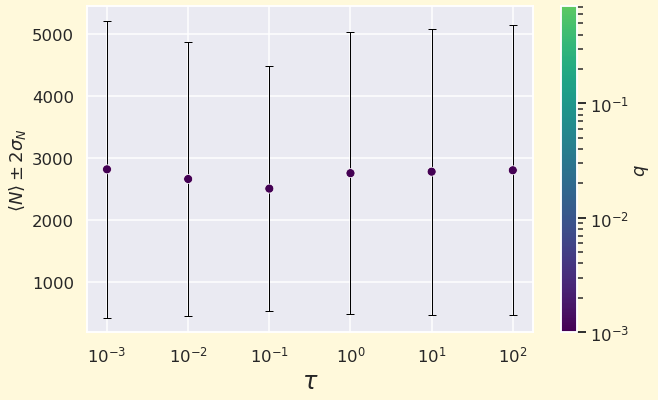

In [74]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
sns.set_style('darkgrid')

# cmap = sns.cubehelix_palette(start=.5, rot=-.45, dark=.2, as_cmap=True, reverse=True)#sns.color_palette('viridis', as_cmap=True)
# cmap = sns.desaturate(cmap, .3)

cmap = ListedColormap(mpl.cm.get_cmap('viridis')(np.linspace(0., 0.75, 256)))

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.scatterplot(data=heat_data[heat_data['inter']==1e-2], x='tau', y='N', hue='inter', style='inter', hue_norm=LogNorm(), palette=cmap, legend=False, zorder=2)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
ax.errorbar(x_coords, y_coords, yerr=2*heat_data[heat_data['inter']==1e-2]['N-std'], fmt='k ', lw=1, capsize=4, capthick=1, zorder=1)

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_ylabel(r'$ \left\langle N \right\rangle \pm 2 \sigma_N $')
ax.set_xlabel(r'$ \tau $', fontsize=24)

psm = ScalarMappable(norm=LogNorm(vmin=inters[::2].min(), vmax=inters[::2].max()), cmap=cmap)
fig.colorbar(psm, ax=ax, label=r'$q$')
# fig.colorbar()
fig.set_facecolor("#fff9db")


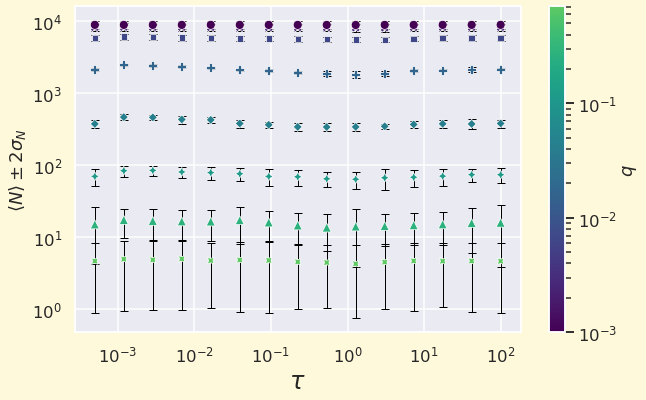

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
sns.set_style('darkgrid')

# cmap = sns.cubehelix_palette(start=.5, rot=-.45, dark=.2, as_cmap=True, reverse=True)#sns.color_palette('viridis', as_cmap=True)
# cmap = sns.desaturate(cmap, .3)

cmap = ListedColormap(mpl.cm.get_cmap('viridis')(np.linspace(0., 0.75, 256)))

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.scatterplot(data=heat_data[heat_data['inter'].isin(inters[::2])], x='tau', y='N', hue='inter', style='inter', hue_norm=LogNorm(), palette=cmap, legend=False, zorder=2)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
ax.errorbar(x_coords, y_coords, yerr=2*heat_data[heat_data['inter'].isin(inters[::2])]['N-std'], fmt='k ', lw=1, capsize=4, capthick=1, zorder=1)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'$ \left\langle N \right\rangle \pm 2 \sigma_N $')
ax.set_xlabel(r'$ \tau $', fontsize=24)

psm = ScalarMappable(norm=LogNorm(vmin=inters[::2].min(), vmax=inters[::2].max()), cmap=cmap)
fig.colorbar(psm, ax=ax, label=r'$q$')
# fig.colorbar()
fig.set_facecolor("#fff9db")


In [19]:
taus = df['tau'].unique()
taus.sort()

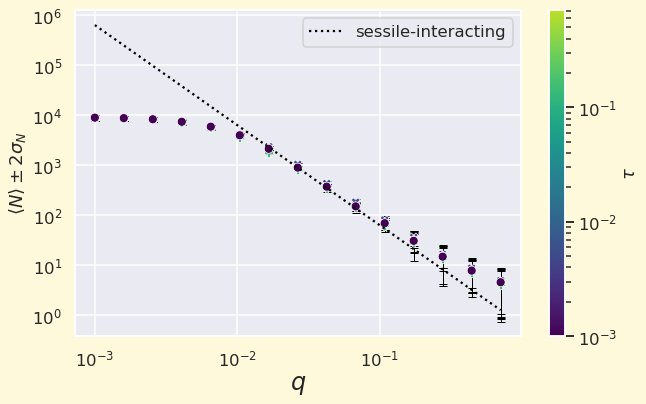

In [25]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
sns.set_style('darkgrid')

# cmap = sns.cubehelix_palette(start=.5, rot=-.45, dark=.2, as_cmap=True, reverse=True)#sns.color_palette('viridis', as_cmap=True)
# cmap = sns.desaturate(cmap, .3)

cmap = ListedColormap(mpl.cm.get_cmap('viridis')(np.linspace(0., 0.9, 256)))

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.scatterplot(data=heat_data[heat_data['tau'].isin(taus[::3])], x='inter', y='N', hue='tau', style='tau', hue_norm=LogNorm(), palette=cmap, legend=False, zorder=2)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
ax.errorbar(x_coords, y_coords, yerr=2*heat_data[heat_data['tau'].isin(taus[::3])]['N-std'], fmt='k ', lw=1, capsize=4, capthick=1, zorder=1)

xs = list(set(x_coords))
xs = sorted(xs)
ys1 = 2*np.array([1/(np.pi*x*x) for x in xs])
# ys2 = np.array([area_dens(x, totarea=1., dens=2*np.pi*np.sqrt(3)/3) for x in xs])
# ys2 = np.array([area_dens(x, totarea=1., dens=np.pi) for x in xs])
ax.plot(xs, ys1, 'k', linestyle=':', label='sessile-interacting')
# ax.plot(xs, ys2, 'k', linestyle='--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'$ \left\langle N \right\rangle \pm 2 \sigma_N $')
ax.set_xlabel(r'$ q $', fontsize=24)

ax.legend()

psm = ScalarMappable(norm=LogNorm(vmin=inters[::2].min(), vmax=inters[::2].max()), cmap=cmap)
fig.colorbar(psm, ax=ax, label=r'$\tau$')
fig.set_facecolor("#fff9db")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ax = plt.gca()
# ax.plot(d['N'].shift(1), d['N'].diff(), 'o')
sns.regplot(x=d['N'].shift(1)[-40:], y=d['N'].diff()[-40:])

In [180]:
u = np.load('np_centers/tau=0.001_inter=0.001_rep=0.npy')

In [184]:
rng = np.random.default_rng()

In [206]:
8*rng.random(size=2)[np.newaxis,:]

array([[3.10272065, 0.70863222]])

In [181]:
u = pd.DataFrame(u)

In [183]:
u.describe()

,0,1
count,8200.000000,8200.000000
mean,0.994045,0.993806
std,0.062725,0.065801
min,0.023686,0.015583
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [259]:
# self.pos_cell_conversion = self.n_cell_divisions/self.env_size
# n_cell_divisions = env_size/inter_radius

rho = np.sqrt(g*tau)*k
radius = rho
env_size = 1.
n_cell_divisions = int(np.floor(env_size/rho))
pos_cell_conversion = n_cell_divisions/env_size

point_adresses= {}

def calculate_point_cell(x, y, pos_cell_conversion):
    return np.floor(x*pos_cell_conversion-1e-5), np.floor(y*pos_cell_conversion-1e-5)

def calculate_points_cells(cell_index, points, pos_cell_conversion):
    for cx in cell_index.keys():
        for cy in cell_index[cx].keys():
            cell_index[cx][cy].clear()

    for x, y in points:
        cx, cy = calculate_point_cell(x=x, y=y, pos_cell_conversion=pos_cell_conversion)
        cell_index[cx][cy].add((x, y))
        point_adresses[(x, y)] = np.array([cx, cy])

    return cell_index, point_adresses

def neighbor_cells(cell_id, n_cell_divisions):
    """A function to calculate all the 

    Args:
        cell_id (int): the index identifying the cell for which the neighbors are to be found

    Returns:
        np.array(int): list of the neighboring cells to the E, NE, N, NW, W, SW, S, SE (in this order)
    """
    L = n_cell_divisions

    # assert 0 <= cell_id, "cell_id must be a positive integer or zero"
    # assert cell_id < L*L, "cell_id must be smaller than L^2"

    cellx, celly = cell_id

    # cell in first row
    test_S = (celly == 0)
    # cell in first column
    test_W = (cellx == 0)
    # cell in last row
    test_N = (celly == L - 1)
    # cell in last column
    test_E = (cellx == L - 1)

    # The cells can be in one of 9 classes of cells:
    #
    # NW | N | NE
    # -- | - | --
    # W  | O | E
    # -- | - | --
    # SW | S | SE             
    # 

    shift_E = np.array([[-L,0], [-L,0], [0,0], [0,0], [0,0], [0,0], [0,0], [-L,0]])
    shift_N = np.array([[0,0], [0,-L], [0,-L], [0,-L], [0,0], [0,0], [0,0], [0,0]])
    shift_W = np.array([[0,0], [0,0], [0,0], [L,0], [L,0], [L,0], [0,0], [0,0]])
    shift_S = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,L], [0,L], [0,L]])

    shift_O = np.array([[cellx+1, celly],[cellx+1, celly+1], [cellx, celly+1], [cellx-1, celly+1], [cellx-1, celly], [cellx-1, celly-1], [cellx, celly-1], [cellx+1, celly-1]])

    return shift_O + test_E*shift_E + test_N*shift_N + test_W*shift_W + test_S*shift_S

def periodic_wrapping_vector(focal_cell, neighbor_cell, n_cell_divisions, env_size=1.):
    """
    I'M ASSUMING THE CELLS TO BE NEIGHBORS
    """
    L = n_cell_divisions - 1

    coefficient = (focal_cell - neighbor_cell)/L
    test_coef = (np.abs(coefficient) == 1.)
    if np.all(~test_coef):
        # no need for periodic vector
        return coefficient

    displacement_vec = np.array([env_size, env_size])
    return displacement_vec*test_coef*coefficient

def ghosted(focal_cell, cell_index, n_cell_divisions, env_size=1.):
    
    cellx, celly = focal_cell
    L = n_cell_divisions
    added_points = []

    # cell in first row
    test_S = (celly == 0)
    # cell in first column
    test_W = (cellx == 0)
    # cell in last row
    test_N = (celly == L - 1)
    # cell in last column
    test_E = (cellx == L - 1)
    
    shift_N = np.array([0, -env_size])
    shift_E = np.array([-env_size, 0])
    shift_S = np.array([0, env_size])
    shift_W = np.array([env_size, 0])

    if test_N and test_E:
        # Nordeste meu amô
        for point in cell_index[cellx][celly]:
            added_points.append(point + shift_N + shift_E)
    if test_N and test_W:
        for point in cell_index[cellx][celly]:
            added_points.append(point + shift_N + shift_W)
    if test_S and test_W:
        for point in cell_index[cellx][celly]:
            added_points.append(point + shift_S + shift_W)
    if test_S and test_E:
        for point in cell_index[cellx][celly]:
            added_points.append(point + shift_S + shift_E)
    if test_N:
        # Nordeste meu amô
        for point in cell_index[cellx][celly]:
            added_points.append(point + shift_N)
    if test_W:
        for point in cell_index[cellx][celly]:
            added_points.append(point + shift_W)
    if test_S:
        for point in cell_index[cellx][celly]:
            added_points.append(point + shift_S)
    if test_E:
        for point in cell_index[cellx][celly]:
            added_points.append(point + shift_E)

    return added_points

def add_ghost_points(centers, n_cell_divisions, cell_index, env_size):
    for i in range(n_cell_divisions):
        for j in range(n_cell_divisions):
            if (i == 0) or (i == n_cell_divisions-1) or (j==0) or (j==n_cell_divisions-1):

                ghostpoints = np.array(ghosted(focal_cell=(i,j), cell_index=cell_index, \
                    n_cell_divisions=n_cell_divisions, env_size=env_size))

                if len(ghostpoints) > 0:
                    centers = np.vstack([centers, ghostpoints])
    return centers


cell_index = {}
for cellx in range(n_cell_divisions):
    cell_index[cellx] = {}
    for celly in range(n_cell_divisions):
        cell_index[cellx][celly] = set()

cell_neighborhood = {cellx: {celly: neighbor_cells(np.array([cellx, celly]), n_cell_divisions=n_cell_divisions) for celly in range(n_cell_divisions)}  for cellx in range(n_cell_divisions)}

periodic_wrapping = {}
for cellx in range(n_cell_divisions):
    periodic_wrapping[cellx] = {}
    for celly in cell_neighborhood[cellx]:
        periodic_wrapping[cellx][celly] = periodic_wrapping_vector(np.array([cellx, celly]), cell_neighborhood[cellx][celly], n_cell_divisions=n_cell_divisions)


centers = np.array(u)
cell_index, point_adresses = calculate_points_cells(cell_index=cell_index, points=centers, pos_cell_conversion=pos_cell_conversion)

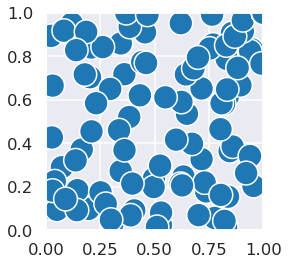

In [260]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.gca()

centers = np.array(u)

# periodic boundary conditions:
add_ghost_points(centers=centers, n_cell_divisions=n_cell_divisions, cell_index=cell_index, env_size=env_size)

g = 1.
tau = 0.001
stdev = np.sqrt(g*tau/2)
k = np.sqrt(-np.log(1-0.95))
rho = np.sqrt(g*tau)*k

for cx, cy in centers:
    c = plt.Circle((cx, cy), radius=(rho))
    ax.add_artist(c)

# ax.set_xlim([0, 1.])
# ax.set_ylim([0, 1.])

ax.set_aspect('equal', adjustable='box')
# plt.show()

In [274]:
import matplotlib.pyplot as plt
import numpy as np


def asympt_distr(x, y, centers, stdev):
    """The idea is to calculate the cumulative probability density of an individual occuppying some spot

    Args:
        x (_type_): _description_
        y (_type_): _description_
        centers (_type_): _description_
        stdev (_type_): _description_

    Returns:
        _type_: _description_
    """
    point_vec = np.array([x,y])
    normal_dis = point_vec - centers
    normal_dis = -np.sum(normal_dis*normal_dis, axis=1)/(2*stdev*stdev)
    normal_dis = np.exp(normal_dis)
    normal_dis = normal_dis/(stdev*np.sqrt(2.*np.pi))
    return np.sum(normal_dis)


# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

x = np.arange(0., env_size, dx)
y = np.arange(0., env_size, dy)
X, Y = np.meshgrid(x, y)
Y = Y[::-1]

# when layering multiple images, the images need to have the same
# extent.  This does not mean they need to have the same shape, but
# they both need to render to the same coordinate system determined by
# xmin, xmax, ymin, ymax.  Note if you use different interpolations
# for the images their apparent extent could be different due to
# interpolation edge effects

nx, ny = X.shape

Z = np.zeros((nx,ny))

centers = np.array(u)

# periodic boundary conditions:
centers = add_ghost_points(centers=centers, n_cell_divisions=n_cell_divisions, cell_index=cell_index, env_size=env_size)

g = 1.
tau = 0.001
stdev = np.sqrt(g*tau/2)

for i in range(nx):
    for j in range(ny):
        Z[i,j] = asympt_distr(X[i,j], Y[i,j], centers=centers, stdev=stdev)

extent = np.min(x), np.max(x), np.min(y), np.max(y)

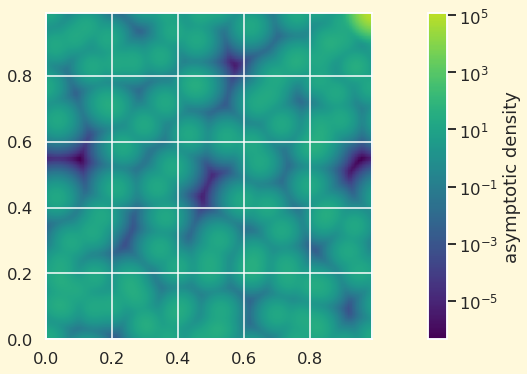

In [284]:
fig, (ax, cax) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(7.5,6))

fig.set_facecolor("#fff9db")

im = ax.imshow(Z, cmap=cmap, interpolation='bilinear',extent=extent, norm=LogNorm())

psm = ScalarMappable(norm=LogNorm(vmin=np.min(Z), vmax=np.max(Z)), cmap=cmap)
fig.colorbar(psm, cax=cax, label='asymptotic density')

plt.show()